In [1]:
#Don't change batch size
batch_size = 64

import itertools

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms


def load_data():
    ## USE THIS SNIPPET TO GET BINARY TRAIN/TEST DATA

    train_data = datasets.MNIST('data/',
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
    test_data = datasets.MNIST('data/',
                               train=False,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    subset_train_indices = ((train_data.train_labels == 0) +
                            (train_data.train_labels == 1)).nonzero().view(-1)
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=False,
        sampler=SubsetRandomSampler(subset_train_indices))


    subset_test_indices = ((test_data.test_labels == 0) +
                           (test_data.test_labels == 1)).nonzero().view(-1)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=False,
        sampler=SubsetRandomSampler(subset_test_indices))

    return train_loader, test_loader

class LogisticRegression(nn.Module):
    def __init__(self, n_feature, n_class):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_feature, n_class)

    def forward(self, x):
        h = self.linear(x)
        return h

    def predict(self, x):
        h = self.linear(x)
        pred = torch.sigmoid(h)
        return torch.where(pred > 0.5,
                           torch.ones(pred.shape),
                           -torch.ones(pred.shape))

class LinearSVM(nn.Module):
    def __init__(self, n_feature, n_class):
        super(LinearSVM, self).__init__()
        self.linear = nn.Linear(n_feature, n_class, bias=True)

    def forward(self, x):
        h = self.linear(x)
        return h

    def predict(self, x):
        h = self.linear(x)
        return torch.sign(h)

def logistic_loss(pred, labels):
    return torch.mean(torch.log(1 + torch.exp(-torch.mul(pred, labels))))

def hinge_loss(pred, labels):
    ywx = torch.mul(pred, labels)
    return torch.mean(torch.max(torch.zeros(ywx.shape), torch.ones(ywx.shape) - ywx))


In [6]:
train_loader, test_loader = load_data()

# Training the Model
# Notice that newest Pytorch merge tensor and variable, so the additional Variable wrapping is no longer required.

D_in, D_out = 784, 1

models = [
    ("LogisticRegression", logistic_loss),
    ("LinearSVM", hinge_loss)
]

model_name_to_class = {
    "LinearSVM": LinearSVM,
    "LogisticRegression": LogisticRegression
}

num_epochs = 10
momentum = 0.9
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]


In [8]:
train_loss = {}

for lr in learning_rates:
    train_loss[lr] = {}
    for use_momentum in [False, True]:
        train_loss[lr][use_momentum] = {}
        if use_momentum:
            print(f"Learning Rate: {lr}\tMomentum:\t{momentum}")
        else:
            print(f"Learning Rate: {lr}")
        for model_name, loss_fn in models:
            train_loss[lr][use_momentum][model_name] = {}
            train_loss[lr][use_momentum][model_name]["train"] = []
            print(model_name)

            model = model_name_to_class[model_name](D_in, D_out)

            if use_momentum:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            for epoch in range(num_epochs):
                total_loss = 0.
                num_batches = 0.
                for i, (images, labels) in enumerate(train_loader):
                    images = Variable(images.view(-1, 28*28))
                    #Convert labels from 0,1 to -1,1
                    labels = Variable(2*(labels.float()-0.5))

                    ## TODO

                    y_pred = model(images).flatten()

                    batch_loss = loss_fn(y_pred, labels)
                    total_loss += batch_loss

                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

                    num_batches += 1.

                avg_loss = total_loss / num_batches
                
                train_loss[lr][use_momentum][model_name]["train"].append(avg_loss)

                # Print your results every epoch
                print(f"Epoch: \t{epoch}\tLoss:\t{avg_loss.item()}")

            # Test the Model
            correct = 0.
            total = 0.
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                #Convert labels from 0,1 to -1,1
                labels = Variable(2*(labels.float()-0.5)).long()

                ## Put your prediction code here
                prediction = model.predict(images)

                correct += (prediction.view(-1).long() == labels).sum()
                total += images.shape[0]
            
            train_loss[lr][use_momentum][model_name]["test"] = (100 * (correct.float() / total))
            print('Accuracy of the model on the test images: %f %%' % (100 * (correct.float() / total)))


Learning Rate: 0.01
LogisticRegression
Epoch: 	0	Loss:	0.036424774676561356
Epoch: 	1	Loss:	0.01066725142300129
Epoch: 	2	Loss:	0.008132115937769413
Epoch: 	3	Loss:	0.0068964422680437565
Epoch: 	4	Loss:	0.006117985118180513
Epoch: 	5	Loss:	0.00558502646163106
Epoch: 	6	Loss:	0.005179067607969046
Epoch: 	7	Loss:	0.004851989448070526
Epoch: 	8	Loss:	0.004580165259540081
Epoch: 	9	Loss:	0.004362890031188726
Accuracy of the model on the test images: 99.905434 %
LinearSVM
Epoch: 	0	Loss:	0.01215823832899332
Epoch: 	1	Loss:	0.003919557668268681
Epoch: 	2	Loss:	0.0033374098129570484
Epoch: 	3	Loss:	0.003006050130352378
Epoch: 	4	Loss:	0.002678008284419775
Epoch: 	5	Loss:	0.002559606684371829
Epoch: 	6	Loss:	0.0023777736350893974
Epoch: 	7	Loss:	0.002282277215272188
Epoch: 	8	Loss:	0.002130890963599086
Epoch: 	9	Loss:	0.0019828237127512693
Accuracy of the model on the test images: 100.000000 %
Learning Rate: 0.01	Momentum:	0.9
LogisticRegression
Epoch: 	0	Loss:	0.01458872202783823
Epoch: 	1	Lo

Epoch: 	4	Loss:	0.46653127670288086
Epoch: 	5	Loss:	0.4306502044200897
Epoch: 	6	Loss:	0.3998015522956848
Epoch: 	7	Loss:	0.37308216094970703
Epoch: 	8	Loss:	0.34971189498901367
Epoch: 	9	Loss:	0.3291468620300293
Accuracy of the model on the test images: 98.061462 %
LinearSVM
Epoch: 	0	Loss:	1.1535612344741821
Epoch: 	1	Loss:	0.926635205745697
Epoch: 	2	Loss:	0.7388003468513489
Epoch: 	3	Loss:	0.5738639235496521
Epoch: 	4	Loss:	0.42035725712776184
Epoch: 	5	Loss:	0.2842639088630676
Epoch: 	6	Loss:	0.19569462537765503
Epoch: 	7	Loss:	0.14828833937644958
Epoch: 	8	Loss:	0.120915487408638
Epoch: 	9	Loss:	0.10324731469154358
Accuracy of the model on the test images: 99.007095 %


In [10]:
import matplotlib.pyplot as plt
import numpy as np

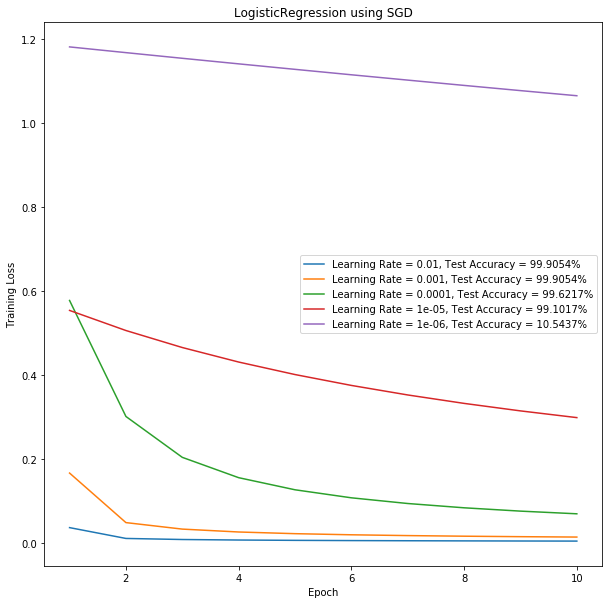

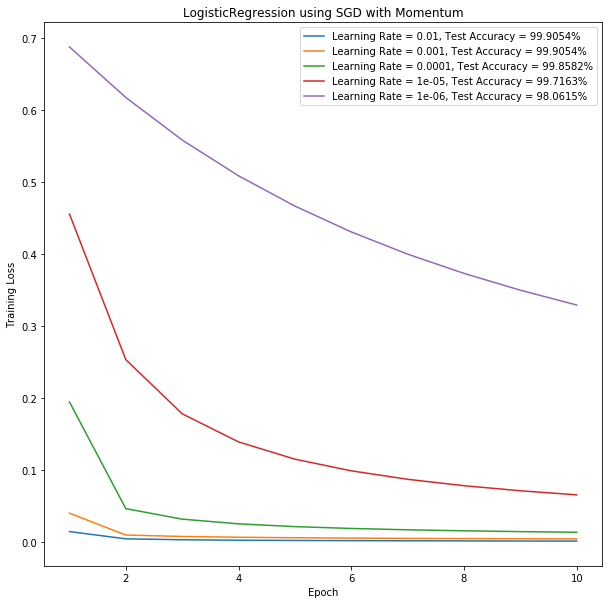

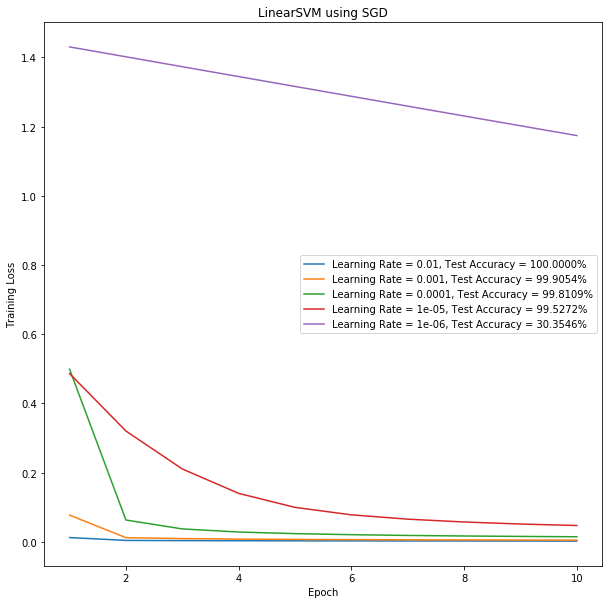

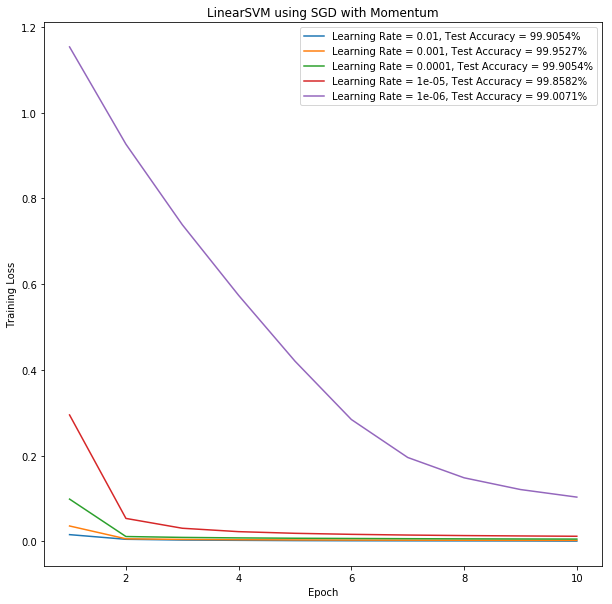

In [27]:
for model_name, loss_fn in models:
    for use_momentum in [False, True]:
        plt.figure(figsize=(10,10))
        for lr in learning_rates:
            acc = train_loss[lr][use_momentum][model_name]["test"]
            plt.plot(np.linspace(1, 10, 10), train_loss[lr][use_momentum][model_name]["train"], 
                     label=f"Learning Rate = {lr}, Test Accuracy = {acc:.4f}%")
            
        if use_momentum:
            plt.title(f"{model_name} using SGD with Momentum")
        else:
            plt.title(f"{model_name} using SGD")
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.legend()
        plt.show()